In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandahouse as ph
from scipy import stats
import os
#импортируем необходимые модули

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': os.environ['KC_PASSWORD'],
    'user': 'student',
    'database': 'simulator_20221120'
}

q = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(q, connection=connection) #подключаемся к базе данных и копируем необходимые данные в DataFrame

<AxesSubplot: xlabel='ctr', ylabel='Count'>

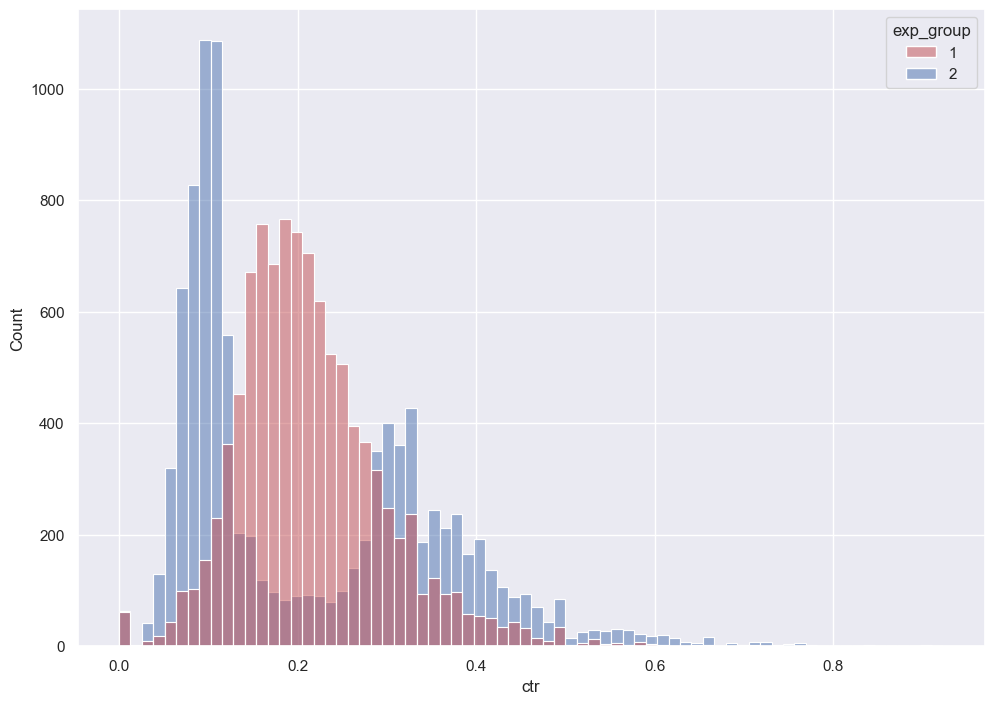

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)}) #делаем графики покрупнее
sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False) #строим распределение ctr внутри групп

Такие результаты AB-теста в экспериментальной группе моглу получиться, если новый алгоритм неправильно работает на какую-то группу пользователей. Например, алгоритм рекомендаций "сломан" на какой-то из ОС.

Распределение ctr внутри 2 группы далеко от нормального, имеет жирные выбросы, поэтому использовать для анализа будем Пуассоновский бутстреп

In [4]:
#пишем функцию для бутстрепа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2 

In [5]:
np.random.seed(1234) #задаем случайное зерно для повторения результатов

In [6]:
#проводим анализ
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot: ylabel='Count'>

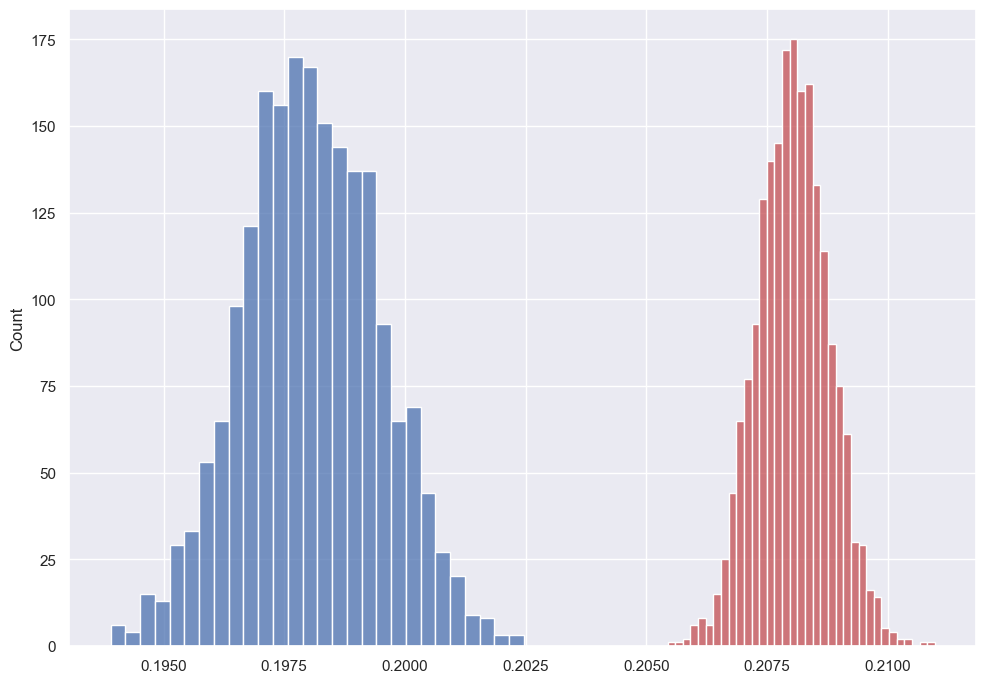

In [7]:
#строим получившееся распределение
sns.histplot(ctr1, color = 'r')
sns.histplot(ctr2)

Такие результаты бутстрепа получились потому, что, несмотря на увеличение ctr для некоторых юзеров, среднегрупповой ctr для 2 группы статистически значимо меньше среднегруппового ctr контрольной группы

In [8]:
sred1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum() 
sred2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()
print('Среднегрупповой ctr первой группы: {:.3}, второй: {:.3}'.format(sred1, sred2))

Среднегрупповой ctr первой группы: 0.208, второй: 0.198


## Вывод
Новый алгоритм в текущем виде раскатывать не стоит, так как, несмотря на улучшение показателей у части пользователей, у значительной части оставшихся произошло заметное ухудшение